In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import os
import shutil
from pathlib import Path

Global stuff

In [2]:
countries = ['NL', 'UK']
corrected_image_dir = 'datasets/news_images_classified_corrected'
image_exts = {".jpg", ".jpeg", ".png"}

In [3]:
nl_classes_by_election_results = [
    'Geert_Wilders',
    'Frans_Timmermans',
    'Dilan_Yesilgoz',
    'Pieter_Omtzigt',
    'Rob_Jetten',
    'Caroline_van_der_Plas',
    'Henri_Bontenbal',
    'Lilian_Marijnissen',
    'Stephan_van_Baarle',
    'Thierry_Baudet',
    'Esther_Ouwehand',
    'Mirjam_Bikker',
    'Chris_Stoffer',
    'Laurens_Dassen',
    'Joost_Eerdmans',
    'Edson_Olf',
    'Wybren_van_Haga',
    'POSSIBLE',
    'UNKNOWN'
]

uk_classes_by_election_results = [# Party name / #seats
    'Keir_Starmer',     # Labour / 411 
    'Rishi_Sunak',      # Conservative / 121
    'Ed_Davey',         # Liberal Democrats / 72
    'John_Swinney',     # Scottish National Party / 9
    'Mary_Lou_McDonald',# Sinn Féin / 7
    'Gavin_Robinson',   # Democratic Unionist / 5
    'Nigel_Farage',     # Reform UK / 5
    'Rhun_ap_Iorwerth', # Plaid Cymru / 4
    'Carla_Denyer',     # Green Party of England and Wales / 4
    'Adrian_Ramsay',    # Green Party of England and Wales / 4
    'Colum_Eastwood',   # Social Democratic & Labour / 2
    'Jim_Allister',     # Tradiitional Unionist Vote / 1
    'Naomi_Long',       # Alliance / 1
    'Doug_Beattie',     # Ulster Unionist / 1
    'Patrick_Harvie',   # Scottish Greens / 0
    'Lorna_Slater',     # Scottish Greens / 0
    'George_Galloway',  # Workers Party / 0 (new)
    'POSSIBLE',
    'UNKNOWN'
    ]

Helper functions

In [33]:
def add_corrected_labels(df, model, country, dir, image_exts=image_exts):
    """
    Finally add corrected label for all predicted politicians and possibly politicians
    """
    label_dir = os.path.join(dir, model, country)
    
    file_to_true_label = {}
    for root, dirs, files in os.walk(label_dir):
        for file in files:
            ext = os.path.splitext(file)[1].lower()
            if ext in image_exts:
                file_path = os.path.join(root, file)
                # Parent folder is the true label after manual correction
                label = os.path.basename(os.path.dirname(file_path))
                file_to_true_label[file] = label
    
    def get_true_label(row):
        if row['final_label_name'] == 'UNKNOWN':
            return 'UNKNOWN'
        filename = os.path.basename(row['image_path'])
        return file_to_true_label.get(filename, None)
    
    df = df.copy()
    df['true_label'] = df.apply(get_true_label, axis=1)
    return df

In [8]:
def add_corrected_labels(df, model, country, dir, image_exts=image_exts):
    """
    Add corrected true_label based on manual drag-and-drop folders,
    with reconciliation for 'possible' predictions that were dragged to UNKNOWN.
    """
    label_dir = os.path.join(dir, model, country)
    
    file_to_true_label = {}
    for root, dirs, files in os.walk(label_dir):
        for file in files:
            ext = os.path.splitext(file)[1].lower()
            if ext in image_exts:
                file_path = os.path.join(root, file)
                # Parent folder is the true label after manual correction
                label = os.path.basename(os.path.dirname(file_path))
                if label == 'UNKNOWN':
                    label = 'POSSIBLE'
                file_to_true_label[file] = label
    
    def get_true_label(row):
        if row['final_label_name'] == 'UNKNOWN':
            return 'UNKNOWN'
        filename = os.path.basename(row['image_path'])
        return file_to_true_label.get(filename, None)
    
    df = df.copy()
    df['true_label'] = df.apply(get_true_label, axis=1)
    
    return df

CM for NL, UK

In [12]:
nl_embedding_predictions_VGGFace = pd.read_parquet('datasets/classified_embeddings/NL_VGG-Face_classified_news_embeddings.parquet')
uk_embedding_predictions_VGGFace = pd.read_parquet('datasets/classified_embeddings/UK_VGG-Face_classified_news_embeddings.parquet')

nl_embedding_predictions_VGGFace['predicted_label'] = nl_embedding_predictions_VGGFace['final_label_name']
uk_embedding_predictions_VGGFace['predicted_label'] = uk_embedding_predictions_VGGFace['final_label_name']

nl_final_labels_VGGFace = add_corrected_labels(nl_embedding_predictions_VGGFace, "VGG-Face", 'NL', corrected_image_dir, image_exts=image_exts)
nl_final_labels_VGGFace = nl_final_labels_VGGFace.drop(columns=['final_label_name'])

uk_final_labels_VGGFace = add_corrected_labels(uk_embedding_predictions_VGGFace, "VGG-Face", 'UK', corrected_image_dir, image_exts=image_exts)
uk_final_labels_VGGFace = uk_final_labels_VGGFace.drop(columns=['final_label_name'])

In [13]:
nl_VGGFace_cm = confusion_matrix(nl_final_labels_VGGFace['true_label'], nl_final_labels_VGGFace['predicted_label'], labels=nl_classes_by_election_results)
nl_VGGFace_cm_normalized = nl_VGGFace_cm.astype('float') / nl_VGGFace_cm.sum(axis=1)[:, np.newaxis]

uk_VGGFace_cm = confusion_matrix(uk_final_labels_VGGFace['true_label'], uk_final_labels_VGGFace['predicted_label'], labels=uk_classes_by_election_results)
uk_VGGFace_cm_normalized = uk_VGGFace_cm.astype('float') / uk_VGGFace_cm.sum(axis=1)[:, np.newaxis]

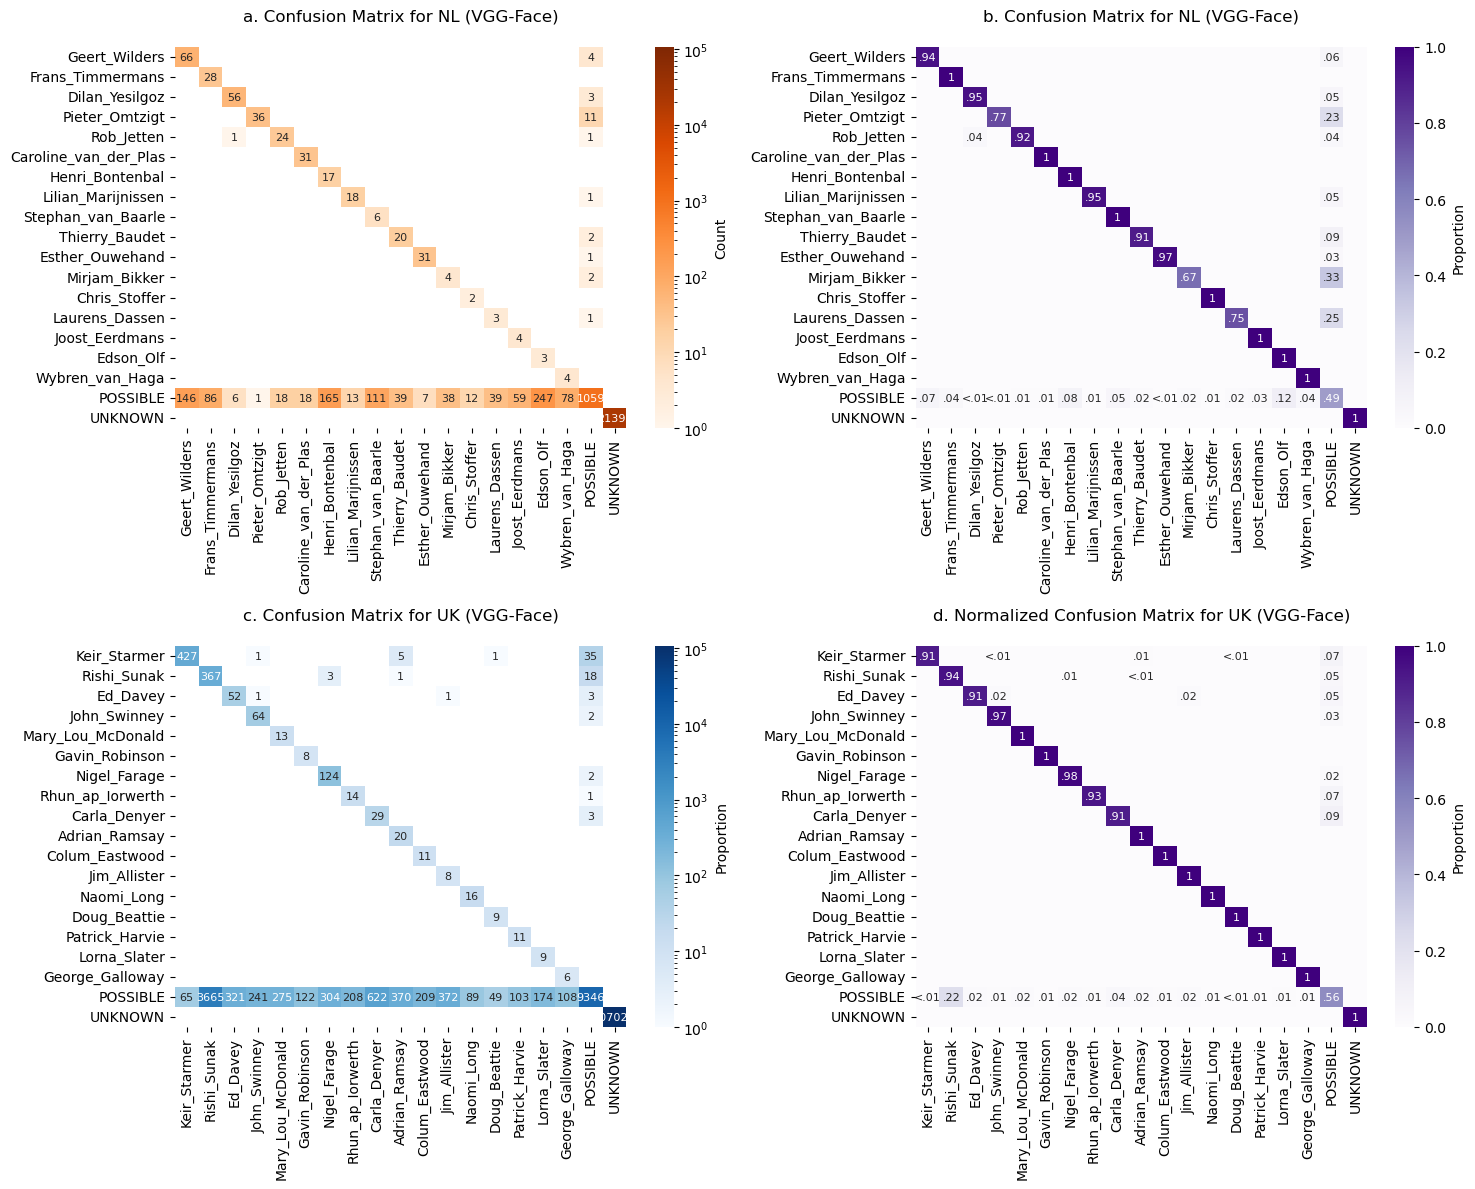

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
norm = mcolors.LogNorm(
    vmin=1,
    vmax=max(nl_VGGFace_cm.max(), uk_VGGFace_cm.max())
)

def fmt_func(value):
    if value == 0:
        return ""
    if value == 1.00:
        return 1
    if value <=0.004:
        return "<.01"
    else:
        return f"{value:.2f}".lstrip('0')

nl_annots = np.array([[fmt_func(v) for v in row] for row in nl_VGGFace_cm_normalized])
uk_annots = np.array([[fmt_func(v) for v in row] for row in uk_VGGFace_cm_normalized])

# Plot NL
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')
axes[0, 0].set_title('a. Confusion Matrix for NL (VGG-Face)\n')

sns.heatmap(nl_VGGFace_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 0], norm=norm, 
            cbar_kws={'label': 'Count'}, xticklabels=nl_classes_by_election_results, yticklabels=nl_classes_by_election_results,
            annot_kws={"size": 8})

axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')
axes[0, 1].set_title('b. Confusion Matrix for NL (VGG-Face)\n')

sns.heatmap(
    nl_VGGFace_cm_normalized, annot=nl_annots, fmt="", cmap="Purples",
    ax=axes[0, 1], xticklabels=nl_classes_by_election_results,
    yticklabels=nl_classes_by_election_results, cbar_kws={'label': 'Proportion'},
    annot_kws={"size": 8}
)

axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')
axes[1, 0].set_title('c. Confusion Matrix for UK (VGG-Face)\n')

# Plot UK
sns.heatmap(uk_VGGFace_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0], norm=norm,
            cbar_kws={'label': 'Proportion'}, xticklabels=uk_classes_by_election_results, yticklabels=uk_classes_by_election_results,
            annot_kws={"size": 8})

axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')
axes[1, 1].set_title('d. Normalized Confusion Matrix for UK (VGG-Face)\n')

sns.heatmap(
    uk_VGGFace_cm_normalized, annot=uk_annots, fmt="", cmap="Purples",
    ax=axes[1, 1], xticklabels=uk_classes_by_election_results,
    yticklabels=uk_classes_by_election_results, cbar_kws={'label': 'Proportion'},
    annot_kws={"size": 8}
)

plt.tight_layout()
#plt.savefig('../z__visual-outputs-matplotlib/confusion_matrices_SVM_t1t2_normalized.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Compute metrics

In [15]:
nl_final_labels_VGGFace['true_label'].value_counts()

true_label
UNKNOWN                  21394
POSSIBLE                  2142
Geert_Wilders               70
Dilan_Yesilgoz              59
Pieter_Omtzigt              47
Esther_Ouwehand             32
Caroline_van_der_Plas       31
Frans_Timmermans            28
Rob_Jetten                  26
Thierry_Baudet              22
Lilian_Marijnissen          19
Henri_Bontenbal             17
Stephan_van_Baarle           6
Mirjam_Bikker                6
Wybren_van_Haga              4
Laurens_Dassen               4
Joost_Eerdmans               4
Edson_Olf                    3
Chris_Stoffer                2
Name: count, dtype: int64

In [ ]:
def compute_metrics(df, unknown_label="UNKNOWN", possible_label='POSSIBLE'):

    y_true = df["true_label"].values
    y_pred = df["predicted_label"].values

    is_actually_unknown = ((y_true == unknown_label) | (y_true == possible_label))
    is_predicted_unknown = ((y_pred == unknown_label) | (y_pred == possible_label))
    is_actually_known = ~is_actually_unknown
    is_predicted_known = ~is_predicted_unknown

    max_scores = df["max_proba"].values
    margins = df["margin"].values

    # --- Politicians vs Unknown ---
    politician_vs_unknown = {
        "politician_vs_unknown_f1": f1_score(is_actually_known, is_predicted_known, zero_division=0),
        "politician_vs_unknown_precision": precision_score(is_actually_known, is_predicted_known, zero_division=0),
        "politician_vs_unknown_recall": recall_score(is_actually_known, is_predicted_known, zero_division=0),
        "unknown_f1": f1_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        "unknown_precision": precision_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        "unknown_recall": recall_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
    }

    # --- Intra-politician discrimination (ignore unknowns) ---
    mask_known = ((y_true != unknown_label) & (y_true != possible_label))
    if mask_known.sum() > 0:
        intra_politician = {
            "intra_politician_f1": f1_score(y_true[mask_known], y_pred[mask_known], average="macro", zero_division=0),
            "intra_politician_precision": precision_score(y_true[mask_known], y_pred[mask_known], average="macro", zero_division=0),
            "intra_politician_recall": recall_score(y_true[mask_known], y_pred[mask_known], average="macro", zero_division=0),
            "intra_politician_f1__weighted": f1_score(y_true[mask_known], y_pred[mask_known], average="weighted", zero_division=0),
            "intra_politician_precision__weighted": precision_score(y_true[mask_known], y_pred[mask_known], average="weighted", zero_division=0),
            "intra_politician_recall__weighted": recall_score(y_true[mask_known], y_pred[mask_known], average="weighted", zero_division=0),
        }

    # --- Global multiclass metrics (incl. unknown) ---
    multiclass = {
        "multiclass_f1": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "multiclass_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "multiclass_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "multiclass_f1__weighted": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "multiclass_precision__weighted": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "multiclass_recall__weighted": recall_score(y_true, y_pred, average="weighted", zero_division=0),
    }

    # --- Summary statistics ---
    stats = {
        "n_politician_true": int(is_actually_known.sum()),
        "n_politician_pred": int(is_predicted_known.sum()),
        "n_unknown_true": int(is_actually_unknown.sum()),
        "n_unknown_pred": int(is_predicted_unknown.sum()),
        "frac_unknown_pred": float(is_predicted_unknown.mean()),
        "frac_unknown_true": float(is_actually_unknown.mean()),
        "mean_max_score": float(np.mean(max_scores)),
        "median_max_score": float(np.median(max_scores)),
        "mean_margin": float(np.mean(margins)),
        "median_margin": float(np.median(margins)),
    }

    # --- Combine all metrics ---
    metrics = {**politician_vs_unknown, **intra_politician, **multiclass, **stats}
    return metrics

In [21]:
nl_metrics = compute_metrics(nl_final_labels_VGGFace, unknown_label="UNKNOWN")
uk_metrics = compute_metrics(uk_final_labels_VGGFace, unknown_label="UNKNOWN")

print("NL metrics:", nl_metrics)
print("UK metrics:", uk_metrics)

NL metrics: {'politician_vs_unknown_f1': 0.3896532746285085, 'politician_vs_unknown_precision': 0.24634655532359082, 'politician_vs_unknown_recall': 0.9315789473684211, 'unknown_f1': 0.9758991633163099, 'unknown_precision': 0.9988433649183682, 'unknown_recall': 0.9539853840924541, 'intra_politician_f1': 0.9072332846008481, 'intra_politician_precision': 0.9434697855750487, 'intra_politician_recall': 0.8790511139958703, 'intra_politician_f1__weighted': 0.9599928431811036, 'intra_politician_precision__weighted': 0.9972760849492152, 'intra_politician_recall__Weighted': 0.9289473684210526, 'multiclass_f1': 0.4697919081129617, 'multiclass_precision': 0.4164640969479188, 'multiclass_recall': 0.9114377795278582, 'multiclass_f1__weighted': 0.963364673059325, 'multiclass_precision__weighted': 0.9907218128269176, 'multiclass_recall__weighted': 0.9535875564475664, 'n_politician_true': 380, 'n_politician_pred': 1437, 'n_unknown_true': 23536, 'n_unknown_pred': 22479, 'frac_unknown_pred': 0.939914701

In [22]:
'''
NL metrics: {'politician_vs_unknown_f1': 0.3896532746285085, 'politician_vs_unknown_precision': 0.24634655532359082, 'politician_vs_unknown_recall': 0.9315789473684211, 'unknown_f1': 0.9758991633163099, 'unknown_precision': 0.9988433649183682, 'unknown_recall': 0.9539853840924541, 'intra_politician_f1': 0.9072332846008481, 'intra_politician_precision': 0.9434697855750487, 'intra_politician_recall': 0.8790511139958703, 'intra_politician_f1__weighted': 0.9599928431811036, 'intra_politician_precision__weighted': 0.9972760849492152, 'intra_politician_recall__Weighted': 0.9289473684210526, 'multiclass_f1': 0.4697919081129617, 'multiclass_precision': 0.4164640969479188, 'multiclass_recall': 0.9114377795278582, 'multiclass_f1__weighted': 0.963364673059325, 'multiclass_precision__weighted': 0.9907218128269176, 'multiclass_recall__weighted': 0.9535875564475664, 'n_politician_true': 380, 'n_politician_pred': 1437, 'n_unknown_true': 23536, 'n_unknown_pred': 22479, 'frac_unknown_pred': 0.9399147014550928, 'frac_unknown_true': 0.9841110553604282, 'mean_max_score': 0.3694141574123053, 'median_max_score': 0.3211228972415786, 'mean_margin': 0.21334169224254934, 'median_margin': 0.13853174822204742}
UK metrics: {'politician_vs_unknown_f1': 0.24603093311482127, 'politician_vs_unknown_precision': 0.14132737114615204, 'politician_vs_unknown_recall': 0.9494071146245059, 'unknown_f1': 0.9693425792882281, 'unknown_precision': 0.9994503418186815, 'unknown_recall': 0.940995722452676, 'intra_politician_f1': 0.9168074476475689, 'intra_politician_precision': 0.9168996989206963, 'intra_politician_recall': 0.9199766933434902, 'intra_politician_f1__weighted': 0.9635942622408131, 'intra_politician_precision__weighted': 0.991003437583376, 'intra_politician_recall__Weighted': 0.9391304347826087, 'multiclass_f1': 0.2810124109323019, 'multiclass_precision': 0.2329844809880882, 'multiclass_recall': 0.9537440995635362, 'multiclass_f1__weighted': 0.9569887240742986, 'multiclass_precision__weighted': 0.9930604786009017, 'multiclass_recall__weighted': 0.9409768357692861, 'n_politician_true': 1265, 'n_politician_pred': 8498, 'n_unknown_true': 123669, 'n_unknown_pred': 116436, 'frac_unknown_pred': 0.9319800854851361, 'frac_unknown_true': 0.9898746538172155, 'mean_max_score': 0.338457613603518, 'median_max_score': 0.29588729995225826, 'mean_margin': 0.18633180992298615, 'median_margin': 0.12107345400796087}'''

"\nNL metrics: {'politician_vs_unknown_f1': 0.3896532746285085, 'politician_vs_unknown_precision': 0.24634655532359082, 'politician_vs_unknown_recall': 0.9315789473684211, 'unknown_f1': 0.9758991633163099, 'unknown_precision': 0.9988433649183682, 'unknown_recall': 0.9539853840924541, 'intra_politician_f1': 0.9072332846008481, 'intra_politician_precision': 0.9434697855750487, 'intra_politician_recall': 0.8790511139958703, 'intra_politician_f1__weighted': 0.9599928431811036, 'intra_politician_precision__weighted': 0.9972760849492152, 'intra_politician_recall__Weighted': 0.9289473684210526, 'multiclass_f1': 0.4697919081129617, 'multiclass_precision': 0.4164640969479188, 'multiclass_recall': 0.9114377795278582, 'multiclass_f1__weighted': 0.963364673059325, 'multiclass_precision__weighted': 0.9907218128269176, 'multiclass_recall__weighted': 0.9535875564475664, 'n_politician_true': 380, 'n_politician_pred': 1437, 'n_unknown_true': 23536, 'n_unknown_pred': 22479, 'frac_unknown_pred': 0.939914

### Summary statistics

In [21]:
final_labels_dict = {
    'NL': nl_final_labels_VGGFace,
    'UK': uk_final_labels_VGGFace
}

In [24]:
def summary_without_duplicates(final_labels_dict, country):
    country_final_labels = final_labels_dict[country]
    print(f'Summary for {country}:')
    print(f'In total, {country_final_labels.shape[0]} faces were cut out from news images.')
    only_political_cutouts = country_final_labels[(country_final_labels['true_label'] != 'UNKNOWN') & (country_final_labels['true_label'] != 'POSSIBLE') ]
    print(f'Out of those facial images, {only_political_cutouts.shape[0]} politicians were detected.')
    political_cutouts_no_dup = only_political_cutouts.drop_duplicates(
        subset=['id_unique', 'true_label'],
        keep='first'
    )
    political_cutouts_no_dup = political_cutouts_no_dup.sort_values(
        by=['id_unique', 'true_label']
    )
    print(f'From that set of true_labels, {only_political_cutouts.shape[0] - political_cutouts_no_dup.shape[0]} duplicates were found, resulting in a final number of {political_cutouts_no_dup.shape[0]} politians.')

    pol_images_grouped_by_id = political_cutouts_no_dup.groupby(['id_unique', 'id', 'outlet'], as_index=False).agg({'true_label': list})
    print(f'Grouping this data by article id, we finally arrive at {pol_images_grouped_by_id.shape[0]} articles containing one or more politicians in the main image.')
    print('* * * * * * * * * * ')
    return pol_images_grouped_by_id

In [25]:
nl_labels_dedup_grouped = summary_without_duplicates(final_labels_dict, 'NL')
uk_labels_dedup_grouped = summary_without_duplicates(final_labels_dict, 'UK')

Summary for NL:
In total, 23916 faces were cut out from news images.
Out of those facial images, 380 politicians were detected.
From that set of true_labels, 1 duplicates were found, resulting in a final number of 379 politians.
Grouping this data by article id, we finally arrive at 283 articles containing one or more politicians in the main image.
* * * * * * * * * * 
Summary for UK:
In total, 124934 faces were cut out from news images.
Out of those facial images, 1265 politicians were detected.
From that set of true_labels, 28 duplicates were found, resulting in a final number of 1237 politians.
Grouping this data by article id, we finally arrive at 1139 articles containing one or more politicians in the main image.
* * * * * * * * * * 


In [26]:
nl_labels_dedup_grouped.to_parquet('datasets/NL_corrected_classifications_VGG-Face_grouped_by_id.parquet')
uk_labels_dedup_grouped.to_parquet('datasets/UK_corrected_classifications_VGG-Face_grouped_by_id.parquet')